In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from lightgbm import LGBMClassifier
import pickle
import joblib

In [10]:
df = pd.read_parquet('../../data/all_data_preprocessed/all_merged_tfidf.parquet')

In [11]:
X = df.drop(columns=[
    'event_all_region', 'alarms_in_regions', 'event_1h_ago',
    'event_2h_ago'])
y = df['event_all_region']
X.rename(columns={"event_1h_ago": "status"}, inplace=True)

In [12]:
tscv = TimeSeriesSplit(n_splits=5)
splits = list(tscv.split(X))
train_idx, test_idx = splits[-1]
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [13]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [14]:
scaler = joblib.load('../our_models/scaler_v1.pkl')
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
weight = sum(y_train==0)/sum(y_train==1)
weight

2.78725174626114

In [16]:
lgb_model = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    device='gpu',
    scale_pos_weight=weight,
    random_state=42,
    n_jobs=1,
    num_leaves=50,
    n_estimators=200,
    learning_rate=0.05
)


In [17]:
param_dist = {
    'learning_rate': [0.03, 0.05, 0.07],
    'num_leaves': [20, 31, 50],
    'n_estimators': [100, 150, 200]
}

In [18]:
# random_search = RandomizedSearchCV(
#     lgb_model,
#     param_distributions=param_dist,
#     n_iter=10,
#     scoring='roc_auc',
#     cv=tscv,
#     verbose=2,
#     random_state=42,
#     n_jobs=8, # change
#     refit=False
# )

In [19]:
# random_search.fit(X_train_scaled, y_train)

In [20]:
# results_df = pd.DataFrame(random_search.cv_results_)
# best_row = results_df.loc[results_df['rank_test_score'] == 1]
# best_params = best_row['params'].values[0]
#
# print(best_params)

In [21]:
# best_lgb = LGBMClassifier(
#     objective='binary',
#     boosting_type='gbdt',
#     scale_pos_weight=weight,
#     n_jobs=-1,
#     random_state=42,
#     **best_params
# )


In [22]:
lgb_model.fit(X_train_scaled, y_train)

[LightGBM] [Info] Number of positive: 137007, number of negative: 381873
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 217326
[LightGBM] [Info] Number of data points in the train set: 518880, number of used features: 1039
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1660 SUPER, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 668 dense feature groups (330.55 MB) transferred to GPU in 0.288479 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.264044 -> initscore=-1.025056
[LightGBM] [Info] Start training from score -1.025056


LGBMClassifier(device='gpu', learning_rate=0.05, n_estimators=200, n_jobs=1,
               num_leaves=50, objective='binary', random_state=42,
               scale_pos_weight=2.78725174626114)

In [23]:
y_pred = lgb_model.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

D:\H2_python_structure_and_data\.venv\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


0.8645351526364478

In [24]:
confusion_matrix(y_test, y_pred)

array([[75365, 10389],
       [ 3669, 14353]])

In [25]:
f1_score(y_test, y_pred)

0.6712655504630063

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.88      0.91     85754
         1.0       0.58      0.80      0.67     18022

    accuracy                           0.86    103776
   macro avg       0.77      0.84      0.79    103776
weighted avg       0.89      0.86      0.87    103776



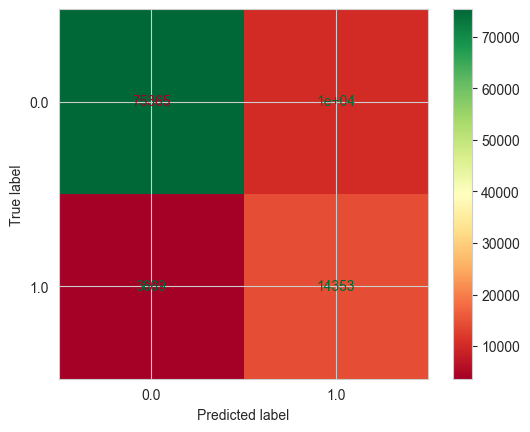

In [27]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='RdYlGn')

In [28]:
with open('../our_models/3__LightGBM__v1.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)